In [1]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainty_utils import *
import controlpy
import tqdm

### Problem setup
Assume the following state space model:
$$ x_{k+1} = Ax_k + Bu_k + w_k \\ y_k = Cx_k + v_k$$
With known noise covariances, and known initial state mean and covariance. C is known, and we have an initial guess of the system dynamics: 
$$ A_{init} = A + \Delta^A, \ \ \ \ \Delta^A_{ij} \sim \mathcal{N}(0, \sigma^2) \\ B_{init} = B + \Delta^B, \ \ \ \ \Delta^B_{ij} \sim \mathcal{N}(0, \sigma^2) $$
With the estimated dynamics, we synthesize an infinite horizon LQR controller, and we use it to estimate the state of the system over the duration of the episode with a Kalman Filter (i.e. we do LQG with the estimated dynamics). When the finite length horizon terminates, we create new estimates of the dynamics from the state-input trajectory as follows:
$$ A^*, B^*\min_{A,B} \sum_{i=0}^{N-1} ||A\hat{x}_i + Bu_i - \hat{x}_{i+1}||_2^2 + \lambda||[A, B]||_F^2$$
After episode i, we update our estimates of the dynamics as:
$$ A_{i+1} = (1-\alpha \gamma^i)A_i + \alpha \gamma^i A^* \\ B_{i+1} = (1-\alpha \gamma^i)B_i + \alpha \gamma^i B^* $$
Where alpha is the learning rate and gamma is the learning rate decay. We synthesize a new LQG controller, and perform another episode of output-feedback control with the new system id, and analyze the convergence of the estimates and trajectories. 

In [2]:
# Dynamics
A_true = np.array([[1,1],[0,1]])
B_true = np.array([0,1]).reshape((2,1))
C = np.array([1,0]).reshape((1,2))
N = A_true.shape[0]
M = B_true.shape[1]
x_init = np.array([12, 0])
input_limits = np.array([-.1,.1])

# LQR Cost:
Q = np.eye(N)
R = np.eye(M)

# Estimation and Simulation
process_noise = 1e-3 * np.eye(N)
measurement_noise = 1e-3 * np.eye(M)
P_init = 1e-3 * np.eye(N)

# Experiment details
num_iterations = 100
regularization = 0
learning_rate = 1
learning_rate_decay = 1
episode_length = 100
sigma_init_id_error = 1e-2
create_animation = True
animation_file = "trajectory.html"

### Show an initial run with the true dynamics

In [3]:
A_init = A_true
B_init = B_true
K, _, _= controlpy.synthesis.controller_lqr_discrete_time(A_init, B_init, Q, R)

In [4]:
x_init_true = x_init + np.random.multivariate_normal(np.zeros(N), P_init)
kf = KF(P_init, process_noise, measurement_noise, A_init, B_init, C, x_init)

In [5]:
x_traj, x_est_traj, u_traj, est_cost, true_opt_cost = sim_traj(A_true, B_true, C,
                                                           K, Q, R,
                                                           process_noise, measurement_noise,
                                                           kf, x_init_true, N=episode_length, input_limits=input_limits)

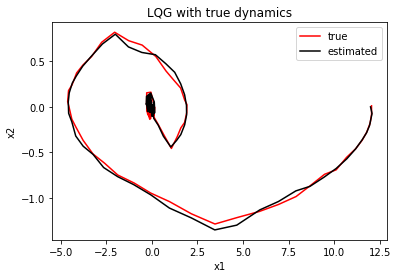

In [6]:
plt.plot(x_traj[:,0], x_traj[:,1],'r')
plt.plot(x_est_traj[:,0], x_est_traj[:,1],'k')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("LQG with true dynamics")
plt.legend(("true", "estimated"))

## Set up iterative certainty equivalence

In [7]:
A_est = A_true + sigma_init_id_error * np.random.randn(N,N)
B_est = B_true + sigma_init_id_error * np.random.randn(N,M)

#A_est[0,1] += sigma_init_id_error

EST_TRAJ = "est_traj"
TRUE_TRAJ = "true_traj"
EST_COST = "est_cost"
TRUE_COST = "true_cost"
INPUT_TRAJ = "input_traj"
ERROR = "reg_error"
A_EST = "A_est"
B_EST = "B_est"

data = {}
data[EST_TRAJ] = []
data[TRUE_TRAJ] = []
data[EST_COST] = []
data[TRUE_COST] = []
data[INPUT_TRAJ] = []
data[ERROR] = []
data[A_EST] = [A_est]
data[B_EST] = [B_est]

### Run initial iteration with random dynamics

In [8]:
x_init_true = x_init + np.random.multivariate_normal(np.zeros(N), P_init)

K, kf = get_LQG(A_est, B_est, C,
                Q, R,
                P_init, process_noise, measurement_noise,
                x_init)

x_traj, x_est_traj, u_traj, est_cost, true_cost = sim_traj(A_true, B_true, C,
                                                           K, Q, R,
                                                           process_noise, measurement_noise,
                                                           kf, x_init_true, N=episode_length, input_limits=input_limits)

data[EST_TRAJ].append(x_est_traj)
data[TRUE_TRAJ].append(x_traj)
data[INPUT_TRAJ].append(u_traj)
data[EST_COST].append(est_cost)
data[TRUE_COST].append(true_cost)

### Run iterative LQG + system ID

In [9]:
for _ in tqdm.tqdm(range(num_iterations)):
    A_est_new, B_est_new, error = regression(data[EST_TRAJ][-1], data[INPUT_TRAJ][-1], regularization)
    A_est = (1 - learning_rate) * A_est + learning_rate * A_est_new
    B_est = (1 - learning_rate) * B_est + learning_rate * B_est_new
    learning_rate *= learning_rate_decay
    x_init_true = x_init + np.random.multivariate_normal(np.zeros(N), P_init)

    K, kf = get_LQG(A_est, B_est, C,
                    Q, R,
                    P_init, process_noise, measurement_noise,
                    x_init)

    x_traj, x_est_traj, u_traj, est_cost, true_cost = sim_traj(A_true, B_true, C,
                                                               K, Q, R,
                                                               process_noise, measurement_noise,
                                                               kf, x_init_true, N=episode_length, input_limits=input_limits)

    data[EST_TRAJ].append(x_est_traj)
    data[TRUE_TRAJ].append(x_traj)
    data[INPUT_TRAJ].append(u_traj)
    data[EST_COST].append(est_cost)
    data[TRUE_COST].append(true_cost)
    data[ERROR].append(error)
    data[A_EST].append(A_est)
    data[B_EST].append(B_est)
    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.88it/s]


## Plot results

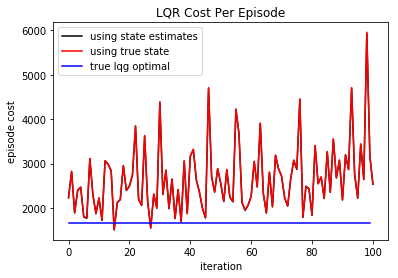

In [10]:
plt.plot(data[EST_COST], 'k')
plt.plot(data[TRUE_COST], 'r-')
plt.plot(true_opt_cost * np.ones(num_iterations), "b")
plt.xlabel("iteration")
plt.ylabel("episode cost")
plt.title("LQR Cost Per Episode")
plt.legend(("using state estimates", "using true state", "true lqg optimal"))

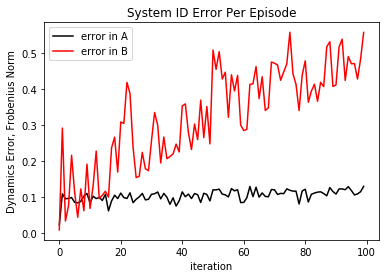

In [11]:
A_error = [np.linalg.norm(data[A_EST][i] - A_true) for i in range(num_iterations)]
B_error = [np.linalg.norm(data[B_EST][i] - B_true) for i in range(num_iterations)]
plt.plot(A_error, "k")
plt.plot(B_error, "r")
plt.xlabel("iteration")
plt.ylabel("Dynamics Error, Frobenius Norm")
plt.title("System ID Error Per Episode")
plt.legend(("error in A", "error in B"))

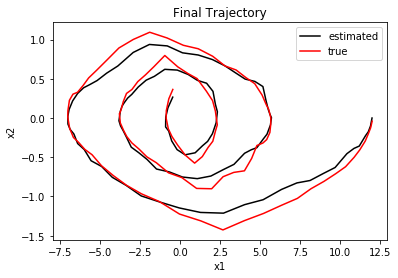

In [12]:
est_traj = data[EST_TRAJ][-1]
true_traj = data[TRUE_TRAJ][-1]
plt.plot(est_traj[:,0], est_traj[:,1], "k")
plt.plot(true_traj[:,0], true_traj[:,1], "r")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Final Trajectory")
plt.legend(("estimated", "true"))

C:\Users\rohan\Anaconda3\lib\site-packages\matplotlib\animation.py:1218: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


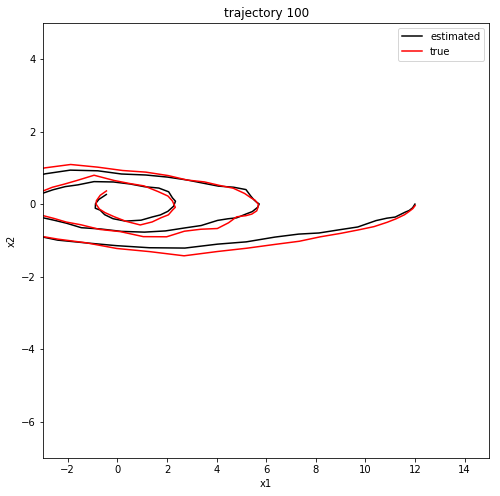

In [13]:
if create_animation:
    animate_trajectories(data, animation_file)